<a href="https://colab.research.google.com/github/santolina/pytorch_handbook/blob/master/PytorchHandbook_chap6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSGAN

In [0]:
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls /content/drive/'My Drive'/'Colab Notebooks'

'BEGAN (1).ipynb'
 BEGAN.ipynb
'Cats-v-Dogs-Augmentation.ipynb のコピー'
 chap9.ipynb
 Colab1-for-deeplearn
'Colorization (1).ipynb'
'Colorization (2).ipynb'
 Colorization.ipynb
'Convolutions Sidebar'
'Coure 3 week 3 text_generation'
'Course 1 - Part 4 - Lesson 2 - Notebook'
'Course 1 - Part 4 - Lesson 4 - Notebook'
'Course 1 - Part 6 - Lesson 2 - Notebook'
'Course 1 - Part 8 - Lesson 4 - Notebook'
'Course 2 - Part 2 - Lesson 3 - Notebook'
'Course 2 - Part 4 - Lesson 2 - Notebook.ipynb のコピー'
'Course 3 - Week 2 - Exercise - Answer'
'Course 3 - Week 2 - Exercise - Question'
'Course 3 - Week 2 - Lesson 1'
'Course 3 - Week 3 - Lesson 1a'
'Course 3 - Week 3 - Lesson 1a (1)'
'Course 3 - Week 3 - Lesson 1b'
'Course 3 - Week 3 - Lesson 2'
'Course 3 - Week 3 - Lesson 2c.ipynb のコピー'
'Course 3 - Week 3 - Lesson 2d'
'Course 4 S+P Week 2 Exercise Answer'
'Course 4 S+P Week 2 Exercise Question'
'Course 4 S+P Week 2 Lesson 2'
'Course 4 S+P Week 3 Exercise Answer.ipynb'
'Course 4 S+P Week 3 Exercise Qu

In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
batch_size=32
num_workers=1
lr = 0.01
beta1 = 0.5
nz = 100
n_epoch=100

In [0]:
# define Generator
class Generator(nn.Module):
  def __init__(self, nz=100, nch_g=64, nch=3):
    """
    nz: # of dimension of input vector
    nch_g: # of input channels at last layer
    nch: # of output channels
    """
    super(Generator, self).__init__()

    # define network
    self.layers = nn.ModuleList([
                                 nn.Sequential(
                                     nn.ConvTranspose2d(nz, nch_g * 8, 4, 1, 0),
                                     nn.BatchNorm2d(nch_g*8),
                                     nn.ReLU()
                                 ),
                                 nn.Sequential(
                                     nn.ConvTranspose2d(nch_g * 8, nch_g * 4, 4, 2, 1),
                                     nn.BatchNorm2d(nch_g * 4),
                                     nn.ReLU()                                     
                                 ),
                                nn.Sequential(
                                     nn.ConvTranspose2d(nch_g * 4, nch_g * 2, 4, 2, 1),
                                     nn.BatchNorm2d(nch_g * 2),
                                     nn.ReLU()                                     
                                 ),
                                nn.Sequential(
                                     nn.ConvTranspose2d(nch_g * 2, nch_g, 4, 2, 1),
                                     nn.BatchNorm2d(nch_g),
                                     nn.ReLU()                                     
                                 ),
                                 nn.Sequential(
                                     nn.ConvTranspose2d(nch_g, nch, 4, 2, 1),
                                     nn.BatchNorm2d(nch),
                                     nn.Tanh()                                    
                                 ) 
    ])

  def forward(self, z):
    """
    z: input vector
    return generated image
    """
    for layer in self.layers:
      z = layer(z)
    return z



In [0]:
class Discriminator(nn.Module):
  def __init__(self, nch=3, nch_d=64):
    super(Discriminator, self).__init__()

    # define network
    self.layers = nn.ModuleList([
                                 nn.Sequential(
                                     nn.Conv2d(nch, nch_d, 4, 2, 1),
                                     nn.LeakyReLU(negative_slope=0.2)                                    
                                 ),
                                 nn.Sequential(
                                     nn.Conv2d(nch_d, nch_d*2, 4, 2,1),
                                     nn.BatchNorm2d(nch_d*2),
                                     nn.LeakyReLU(negative_slope=0.2)                                    
                                 ),
                                 nn.Sequential(
                                     nn.Conv2d(nch_d*2, nch_d*4, 4, 2,1),
                                     nn.BatchNorm2d(nch_d*4),
                                     nn.LeakyReLU(negative_slope=0.2)                                    
                                 ),
                                 nn.Sequential(
                                     nn.Conv2d(nch_d*4, nch_d*8, 4, 2,1),
                                     nn.BatchNorm2d(nch_d*8),
                                     nn.LeakyReLU(negative_slope=0.2)                                    
                                 ),
                                 nn.Conv2d(nch_d*8, 1, 4, 1, 0)
    ])

  def forward(self, z):
    """
    z: input vector
    return generated image
    """
    for layer in self.layers:
      z = layer(z)
    return z
  

In [0]:
# define model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

netG = Generator()
netG = netG.to(device)

netD = Discriminator()
netD = netD.to(device)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)



In [6]:
netG

Generator(
  (layers): ModuleList(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(

In [7]:
netD

Discriminator(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [25]:
# load STL-10 training dataset
trainset = torchvision.datasets.STL10(root='stl10_root', download=True, split='train+unlabeled',
                                      transform=transforms.Compose([
                                                                    transforms.RandomResizedCrop(64, scale=(88/96, 1.0), ratio=(1.,1.)),
                                                                    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

                                      ])
                                      )


testset = torchvision.datasets.STL10(root='stl10_root', download=True, split='test',
                                      transform=transforms.Compose([
                                                                    transforms.RandomResizedCrop(64, scale=(88/96, 1.0), ratio=(1.,1.)),
                                                                    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

                                      ])
                                      )

dataset = trainset + testset # combined dataset is used as training data

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=int(num_workers))

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# loss function and optimizer
criterion = nn.MSELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

fixed_noise= torch.randn(batch_size, nz, 1, 1, device=device)

# Training


In [26]:
outf="/content/drive/My Drive/Colab Notebooks/pytorch_handbook"

# training
for epoch in range(n_epoch):
  for itr, data in enumerate(dataloader):
    real_image = data[0].to(device)
    sample_size = real_image.size(0)

    noise = torch.randn(sample_size, nz, 1, 1, device=device)

    real_target = torch.full((sample_size,), 1., device=device)
    fake_target = torch.full((sample_size,), 0., device=device)

    ################################
    # update netD
    ################################
    netD.zero_grad()

    output = netD(real_image)
    errD_real = criterion(output, real_target)

    D_x = output.mean().item()

    fake_image = netG(noise)

    output = netD(fake_image.detach())

    errD_fake = criterion(output, fake_target)

    D_G_z1 = output.mean().item()


    errD = errD_real + errD_fake

    errD.backward()

    optimizerD.step()

    ################################
    # update netG
    ################################
    netG.zero_grad()

    output = netD(fake_image)
    errG = criterion(output, real_target)
    D_G_z2 = output.mean().item()

    errG.backward()
    optimizerG.step()

    ################################
    # show current status
    ################################
    if itr%100==0:
      print('[{}/{}][{}/{}] Loss_D:{:.3f} Loss_G:{:.3f} D(x):{:.3f} D(G(z)):{:.3f}/{:.3f}'.format(
        epoch+1, n_epoch, itr + 1, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch==0 and itr==0:
      torchvision.utils.save_image(real_image, '{}/real_samples.png'.format(outf), normalize=True, nrow=10)

  # output fake image per epch
  fake_image = netG(fixed_noise)
  torchvision.utils.save_image(fake_image.detach(), 
                               '{}/fake_samples_epoch_{:03d}.png'.format(outf, epoch+1), 
                               normalize=True, 
                               nrow=10)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1/100][1/3532] Loss_D:0.277 Loss_G:0.551 D(x):0.723 D(G(z)):0.080/0.276
[1/100][2/3532] Loss_D:0.186 Loss_G:0.763 D(x):0.905 D(G(z)):0.238/0.177
[1/100][3/3532] Loss_D:0.206 Loss_G:0.965 D(x):1.008 D(G(z)):0.161/0.044
[1/100][4/3532] Loss_D:0.325 Loss_G:0.596 D(x):0.568 D(G(z)):0.164/0.234
[1/100][5/3532] Loss_D:0.111 Loss_G:0.902 D(x):0.924 D(G(z)):0.184/0.078
[1/100][6/3532] Loss_D:0.156 Loss_G:0.781 D(x):0.824 D(G(z)):0.145/0.128
[1/100][7/3532] Loss_D:0.306 Loss_G:0.278 D(x):0.615 D(G(z)):0.065/0.496
[1/100][8/3532] Loss_D:0.334 Loss_G:1.376 D(x):1.094 D(G(z)):0.489/-0.126
[1/100][9/3532] Loss_D:0.276 Loss_G:0.627 D(x):0.662 D(G(z)):-0.069/0.222
[1/100][10/3532] Loss_D:0.207 Loss_G:1.264 D(x):1.021 D(G(z)):0.254/-0.101
[1/100][11/3532] Loss_D:0.351 Loss_G:0.330 D(x):0.592 D(G(z)):-0.084/0.471
[1/100][12/3532] Loss_D:0.618 Loss_G:2.676 D(x):1.133 D(G(z)):0.536/-0.497
[1/100][13/3532] Loss_D:0.941 Loss_G:0.252 D(x):0.447 D(G(z)):-0.332/0.805
[1/100][14/3532] Loss_D:0.988 Loss_G:2.27

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[2/100][1/3532] Loss_D:0.319 Loss_G:1.165 D(x):0.783 D(G(z)):0.214/-0.062
[2/100][2/3532] Loss_D:0.322 Loss_G:0.665 D(x):0.655 D(G(z)):0.262/0.224
[2/100][3/3532] Loss_D:0.348 Loss_G:1.307 D(x):0.797 D(G(z)):0.410/-0.120
[2/100][4/3532] Loss_D:0.337 Loss_G:1.264 D(x):0.753 D(G(z)):0.349/-0.112
[2/100][5/3532] Loss_D:0.504 Loss_G:0.340 D(x):0.384 D(G(z)):0.166/0.469
[2/100][6/3532] Loss_D:0.733 Loss_G:2.078 D(x):0.875 D(G(z)):0.768/-0.370
[2/100][7/3532] Loss_D:0.656 Loss_G:0.597 D(x):0.340 D(G(z)):-0.083/0.419
[2/100][8/3532] Loss_D:0.510 Loss_G:0.800 D(x):0.840 D(G(z)):0.503/0.132
[2/100][9/3532] Loss_D:0.319 Loss_G:1.670 D(x):0.946 D(G(z)):0.269/-0.216
[2/100][10/3532] Loss_D:0.564 Loss_G:0.750 D(x):0.535 D(G(z)):0.011/0.317
[2/100][11/3532] Loss_D:0.441 Loss_G:1.356 D(x):1.035 D(G(z)):0.433/-0.136
[2/100][12/3532] Loss_D:0.346 Loss_G:0.805 D(x):0.640 D(G(z)):0.240/0.122
[2/100][13/3532] Loss_D:0.309 Loss_G:0.788 D(x):0.672 D(G(z)):0.289/0.126
[2/100][14/3532] Loss_D:0.470 Loss_G:2.1

KeyboardInterrupt: ignored

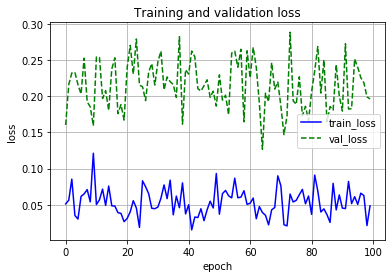

In [0]:
num_epoch=100
plt.figure()

plt.plot(range(num_epoch), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epoch), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.show()


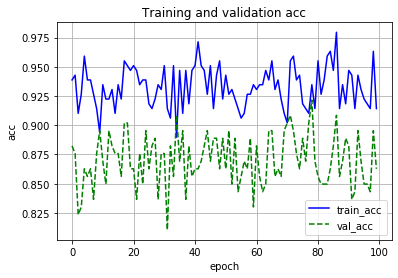

In [0]:
num_epoch=100
plt.figure()

plt.plot(range(num_epoch), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epoch), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation acc')
plt.grid()
plt.show()

# dataloader using ImageFolder

In [0]:
data_dir = './hymenoptera_data'

train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
test_dataset  = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4)


In [0]:
# optimization and scheduler
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
train_loss_list, train_acc_list, val_loss_list, val_acc_list, net = train(net, criterion, optimizer, train_loader, test_loader, device, lr_scheduler, num_epoch=100)

Epoc [1/100], loss: 0.0284, val_loss: 0.0168, val_acc: 0.9150, lr:0.01
Epoc [2/100], loss: 0.0222, val_loss: 0.0206, val_acc: 0.9020, lr:0.01
Epoc [3/100], loss: 0.0186, val_loss: 0.0210, val_acc: 0.9020, lr:0.01
Epoc [4/100], loss: 0.0282, val_loss: 0.0247, val_acc: 0.8431, lr:0.01
Epoc [5/100], loss: 0.0299, val_loss: 0.0421, val_acc: 0.8627, lr:0.01
Epoc [6/100], loss: 0.0220, val_loss: 0.0307, val_acc: 0.8889, lr:0.01
Epoc [7/100], loss: 0.0202, val_loss: 0.0336, val_acc: 0.9085, lr:0.01
Epoc [8/100], loss: 0.0130, val_loss: 0.0353, val_acc: 0.9150, lr:0.01
Epoc [9/100], loss: 0.0199, val_loss: 0.0289, val_acc: 0.8954, lr:0.01
Epoc [10/100], loss: 0.0125, val_loss: 0.0296, val_acc: 0.8824, lr:0.01
Epoc [11/100], loss: 0.0081, val_loss: 0.0311, val_acc: 0.8889, lr:0.01
Epoc [12/100], loss: 0.0092, val_loss: 0.0361, val_acc: 0.8627, lr:0.01
Epoc [13/100], loss: 0.0082, val_loss: 0.0368, val_acc: 0.9020, lr:0.01
Epoc [14/100], loss: 0.0080, val_loss: 0.0406, val_acc: 0.8497, lr:0.01
E

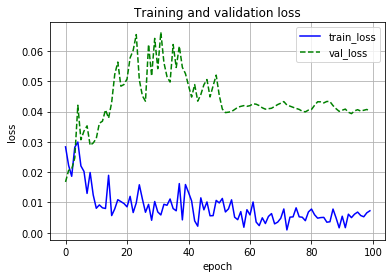

In [0]:
num_epoch=100
plt.figure()

plt.plot(range(num_epoch), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epoch), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.show()

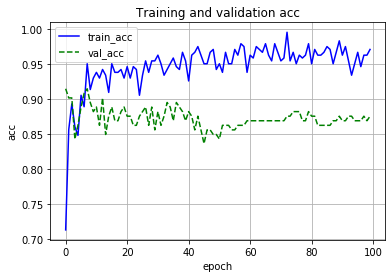

In [0]:
num_epoch=100
plt.figure()

plt.plot(range(num_epoch), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epoch), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation acc')
plt.grid()
plt.show()